In [242]:

import pandas as pd
import sys
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [243]:
sys.path.insert(0,"..")
bremen_trips = pd.read_csv("../data/processed/trips.csv")
bremen_trips = bremen_trips.sort_values(by=['start_time'], ascending=True)
bremen_trips["start_time"] = pd.to_datetime(bremen_trips["start_time"])
bremen_trips = bremen_trips[(bremen_trips['start_lng'] != bremen_trips['end_lng']) | (bremen_trips['start_lat'] != bremen_trips['end_lat'])]

In [244]:

for col in ['start_time']:
    bremen_trips['month'] = pd.DatetimeIndex(bremen_trips['start_time']).month
    bremen_trips['booking_date'] = bremen_trips.start_time.dt.date
    bremen_trips['weekdays'] = pd.DatetimeIndex(bremen_trips['start_time']).weekday

In [245]:
bremen_trips.head()


,bike,bike_type,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,end_place,month,booking_date,weekdays
50911,20685,71,12099440,2019-01-20 00:13:00,2019-01-20 00:23:00,600.0,8.812554,53.076481,8.804828,53.084196,0.0,0.0,1,2019-01-20,6
126358,20935,71,7873316,2019-01-20 00:35:00,2019-01-25 08:00:00,458700.0,8.816798,53.072448,8.811472,53.083167,0.0,2946.0,1,2019-01-20,6
30807,20617,71,12099749,2019-01-20 00:40:00,2019-01-20 00:44:00,240.0,8.801623,53.067878,8.793217,53.064244,0.0,0.0,1,2019-01-20,6
81651,20795,71,12099872,2019-01-20 00:47:00,2019-01-20 00:54:00,420.0,8.814744,53.084841,8.801135,53.094596,0.0,0.0,1,2019-01-20,6
123835,20927,71,12100199,2019-01-20 01:07:00,2019-01-20 01:15:00,480.0,8.815254,53.084302,8.806666,53.094964,0.0,0.0,1,2019-01-20,6


In [246]:
bremen_trips['duration_min'] = bremen_trips['duration_sec']/60

In [247]:
# drop entries with booking durations longer than 2 days
bremen_trips = bremen_trips[bremen_trips['duration_min'] < 200]
# bremen_trips = bremen_trips[(bremen_trips['start_place'] != 0) & (bremen_trips['end_place'] != 0)]
bremen_trips = bremen_trips[bremen_trips['month'] != 1]

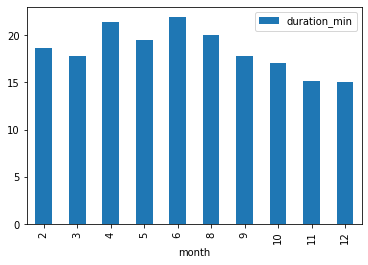

In [248]:
# avg duration per month (looks like we have some outliers)

df = bremen_trips.groupby('month').duration_min.mean().to_frame()
df.plot(kind="bar")

In [249]:
bremen_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134220 entries, 103417 to 70657
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   bike            134220 non-null  int64         
 1   bike_type       134220 non-null  int64         
 2   identification  134220 non-null  int64         
 3   start_time      134220 non-null  datetime64[ns]
 4   end_time        134220 non-null  object        
 5   duration_sec    134220 non-null  float64       
 6   start_lng       134220 non-null  float64       
 7   start_lat       134220 non-null  float64       
 8   end_lng         134220 non-null  float64       
 9   end_lat         134220 non-null  float64       
 10  start_place     134220 non-null  float64       
 11  end_place       134220 non-null  float64       
 12  month           134220 non-null  int64         
 13  booking_date    134220 non-null  object        
 14  weekdays        134220 non-null 

In [250]:
data_raw = bremen_trips[['bike','bike_type','identification', 'start_time', 'duration_min', 'start_lng', 'start_lat', 'start_place', 'month', 'weekdays']]

In [251]:
data_raw['hour'] = data_raw['start_time'].dt.hour
data_raw['min'] = data_raw['start_time'].dt.minute
data_raw['day_of_month'] = data_raw['start_time'].dt.day
data_raw.drop(axis = 1, columns = 'start_time', inplace=True)

C:\Users\TomCLG\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\TomCLG\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\TomCLG\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [252]:
# get uniformative features meaning that they contain over 95% of the time the same value
num_rows = len(data_raw.index)
low_information_cols = [] #

for col in data_raw.columns:
    cnts = data_raw[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

bike_type: 99.88005%
71    134059
29       161
Name: bike_type, dtype: int64



In [253]:
data_raw.drop(columns=["bike_type", "identification", "bike"], inplace=True)

In [254]:
#data_raw['is_freefloat'] = np.where(data_raw['start_place'] == 0, 1, 0)


In [255]:
data_raw

,duration_min,start_lng,start_lat,start_place,month,weekdays,hour,min,day_of_month
103417,12.0,8.813245,53.082316,0.0,2,4,0,2,1
121713,12.0,8.813730,53.082089,0.0,2,4,0,2,1
89995,34.0,8.824117,53.073259,0.0,2,4,0,55,1
43535,8.0,8.812629,53.073757,0.0,2,4,1,11,1
101977,6.0,8.808783,53.070053,0.0,2,4,5,11,1
...,...,...,...,...,...,...,...,...,...
135681,8.0,8.871098,53.077498,0.0,12,1,23,41,31
71959,15.0,8.821334,53.081942,0.0,12,1,23,44,31
129485,7.0,8.779235,53.078581,2966.0,12,1,23,48,31
76741,7.0,8.779235,53.078581,2966.0,12,1,23,48,31


In [256]:
data_raw.corrwith(data_raw['duration_min'])

duration_min    1.000000
start_lng       0.012801
start_lat       0.039615
start_place     0.049020
month          -0.066348
weekdays        0.076088
hour           -0.005037
min            -0.013441
day_of_month    0.017529
dtype: float64

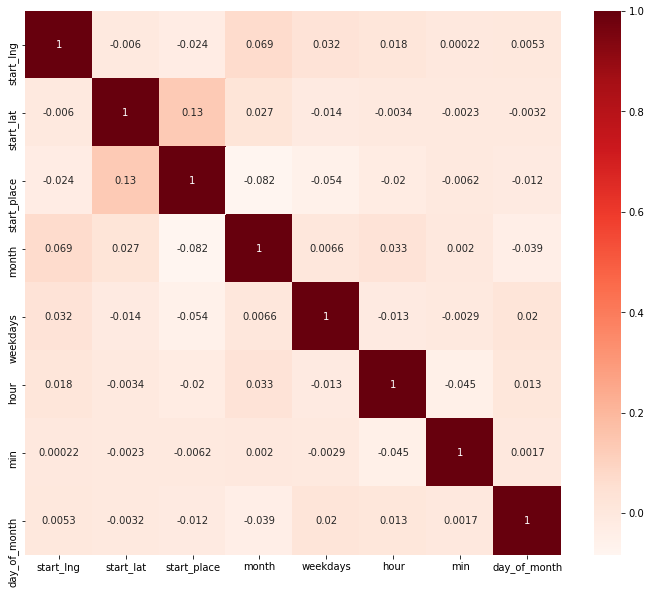

In [257]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data_raw.loc[:, data_raw.columns != 'duration_min'].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [206]:
data_raw.head()

,duration_min,start_lng,start_lat,start_place,month,weekdays,hour,min,day_of_month
50911,10.0,8.812554,53.076481,0.0,1,6,0,13,20
30807,4.0,8.801623,53.067878,0.0,1,6,0,40,20
81651,7.0,8.814744,53.084841,0.0,1,6,0,47,20
123835,8.0,8.815254,53.084302,0.0,1,6,1,7,20
135279,18.0,8.809818,53.083648,0.0,1,6,1,36,20


In [207]:
X = data_raw.loc[:, data_raw.columns != 'duration_min']
y = data_raw['duration_min']

In [208]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139416 entries, 50911 to 70657
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   start_lng     139416 non-null  float64
 1   start_lat     139416 non-null  float64
 2   start_place   139416 non-null  float64
 3   month         139416 non-null  int64  
 4   weekdays      139416 non-null  int64  
 5   hour          139416 non-null  int64  
 6   min           139416 non-null  int64  
 7   day_of_month  139416 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 9.6 MB


In [209]:
X.head()

,start_lng,start_lat,start_place,month,weekdays,hour,min,day_of_month
50911,8.812554,53.076481,0.0,1,6,0,13,20
30807,8.801623,53.067878,0.0,1,6,0,40,20
81651,8.814744,53.084841,0.0,1,6,0,47,20
123835,8.815254,53.084302,0.0,1,6,1,7,20
135279,8.809818,53.083648,0.0,1,6,1,36,20


In [210]:
from sklearn.model_selection import train_test_split


X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=False)

In [211]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [212]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)

In [213]:
lin = LinearRegression()

In [214]:
lin.fit(X_train_poly, y_train)
lin.score(X_train_poly, y_train)

0.011765339655731899

In [215]:
lin.fit(X_train_poly, y_train)
lin.score(X_train_poly, y_train)

0.011765339655731899

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [22]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestRegressor(criterion='mse')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='r2', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [23]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

KeyboardInterrupt: 

In [25]:
rf = RandomForestRegressor(criterion='mse', max_depth=5, n_estimators=512, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=512, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [26]:
y_pred = rf.predict(X_train)

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
mean_squared_error(y_train, y_pred)

145.00243716852808